# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
plt.style.use('fivethirtyeight')

## Read the CSV and Perform Basic Data Cleaning

In [5]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [6]:
# create dataframe to store all the report outcomes for final analysis
keys = ["avg_iba","avg_rec","avg_geo","avg_f1"]
df_model_analysis = pd.DataFrame(columns = ["Model","avg_iba","avg_rec","avg_geo","avg_f1"]).set_index("Model")

## Split the Data into Training and Testing

In [7]:
# Create our features
X = df.drop(columns='loan_status')
X = pd.get_dummies(X)

# Create our target
y = df[["loan_status"]].copy()

In [8]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [9]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [10]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [11]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [12]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [13]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [14]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
bal_rand_for = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
bal_rand_for.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(random_state=1)

In [15]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
y_bal_rand_pred = bal_rand_for.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_bal_rand_pred)

0.7887512850910909

In [16]:
# Display the confusion matrix
# YOUR CODE HERE
cm=confusion_matrix(y_test, y_bal_rand_pred)
cm

array([[   71,    30],
       [ 2146, 14958]], dtype=int64)

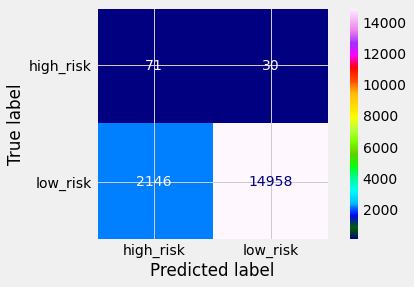

In [17]:
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=bal_rand_for.classes_)
disp.plot(cmap="gist_ncar");

In [18]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_bal_rand_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.70      0.87      0.06      0.78      0.60       101
   low_risk       1.00      0.87      0.70      0.93      0.78      0.63     17104

avg / total       0.99      0.87      0.70      0.93      0.78      0.63     17205



In [19]:
# adding report information to a data frame for analysis
#get report in dictionary
report = classification_report_imbalanced(y_test, y_bal_rand_pred,output_dict=True)
report_extract = { key: report[key] for key in keys }
report_extract["Model"] = "Balanced Random Forest Classifier"
df_model_analysis = df_model_analysis.append(pd.DataFrame.from_dict(report_extract,orient="index").T.set_index("Model"))

In [20]:
# List the features sorted in descending order by feature importance
importances = bal_rand_for.feature_importances_ 
#matching the importance to its feature using the zip function 
# use sort to sort based on importance and reverse to get descending
feature_imp_sorted = sorted(zip(X.columns, importances), key = lambda x: x[1],reverse=True)
for f in feature_imp_sorted:
    print(f"Feature '{f[0]}' has importance: ({f[1]} )")

Feature 'total_rec_prncp' has importance: (0.07876809003486353 )
Feature 'total_pymnt' has importance: (0.05883806887524815 )
Feature 'total_pymnt_inv' has importance: (0.05625613759225244 )
Feature 'total_rec_int' has importance: (0.05355513093134745 )
Feature 'last_pymnt_amnt' has importance: (0.0500331813446525 )
Feature 'int_rate' has importance: (0.02966959508700077 )
Feature 'issue_d_Jan-2019' has importance: (0.021129125328012987 )
Feature 'installment' has importance: (0.01980242888931366 )
Feature 'dti' has importance: (0.01747062730041245 )
Feature 'out_prncp_inv' has importance: (0.016858293184471483 )
Feature 'total_bal_ex_mort' has importance: (0.01641297102011915 )
Feature 'mths_since_recent_inq' has importance: (0.015220714904737209 )
Feature 'issue_d_Mar-2019' has importance: (0.015115240704562424 )
Feature 'revol_bal' has importance: (0.014926655663448373 )
Feature 'max_bal_bc' has importance: (0.014899352873994727 )
Feature 'out_prncp' has importance: (0.0148810690230

In [21]:
# same using dataframes
feature_imp_df = pd.DataFrame(list(zip(X.columns, importances)), columns = ['Feature', 'Importance']).set_index("Feature")
feature_imp_df.sort_values(by="Importance", ascending=False,inplace=True)
feature_imp_df

,Importance
Feature,
total_rec_prncp,0.078768
total_pymnt,0.058838
total_pymnt_inv,0.056256
total_rec_int,0.053555
last_pymnt_amnt,0.050033
...,...
collection_recovery_fee,0.000000
policy_code,0.000000
acc_now_delinq,0.000000


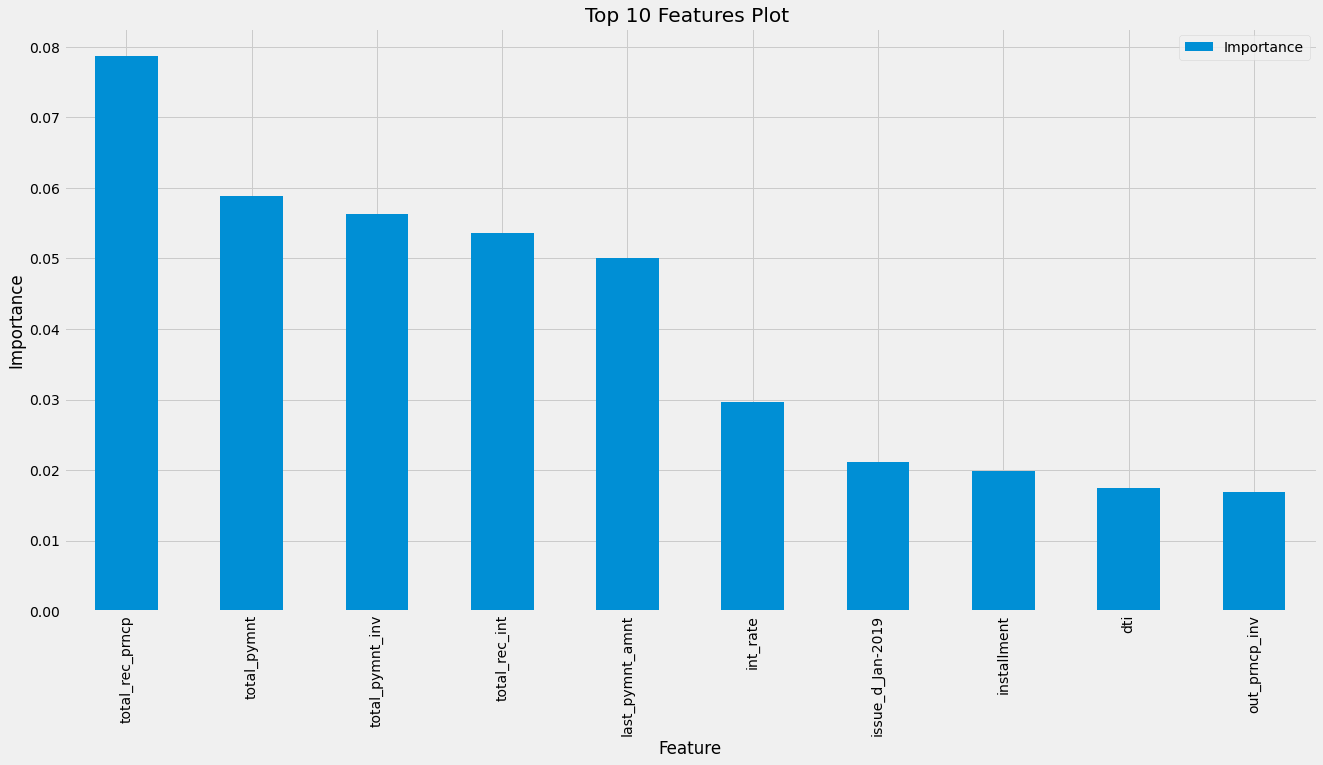

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
feature_imp_df[:10].plot.bar(ax=ax,grid=True,figsize=(20,10))
ax.set_title("Top 10 Features Plot ")
ax.set_ylabel("Importance")
fig.show()

### Easy Ensemble Classifier

In [23]:
# Train the Classifier
from imblearn.ensemble import EasyEnsembleClassifier
easy_ens_class = EasyEnsembleClassifier(n_estimators=100, random_state=1)
easy_ens_class.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [24]:
# Calculated the balanced accuracy score
y_easy_ens_pred = easy_ens_class.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_easy_ens_pred)

0.931601605553446

In [25]:
# Display the confusion matrix
cm=confusion_matrix(y_test, y_easy_ens_pred)
cm

array([[   93,     8],
       [  985, 16119]], dtype=int64)

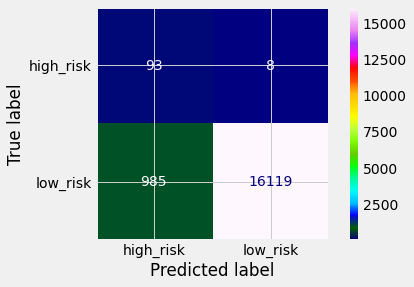

In [26]:
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=easy_ens_class.classes_)
disp.plot(cmap="gist_ncar");

In [27]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_easy_ens_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205



In [28]:
# adding report information to a data frame for analysis
#get report in dictionary
report = classification_report_imbalanced(y_test, y_easy_ens_pred,output_dict=True)
report_extract = { key: report[key] for key in keys }
report_extract["Model"] = "Easy Ensemble Classifier"
df_model_analysis = df_model_analysis.append(pd.DataFrame.from_dict(report_extract,orient="index").T.set_index("Model"))

## Analysis

In [29]:
#cummulative report
df_model_analysis

,avg_iba,avg_rec,avg_geo,avg_f1
Model,,,,
Balanced Random Forest Classifier,0.625193,0.873525,0.784073,0.927082
Easy Ensemble Classifier,0.869619,0.942284,0.931539,0.965349


In [30]:
# order by balanced accuracy
df_model_analysis.sort_values(by="avg_iba",ascending=False)

,avg_iba,avg_rec,avg_geo,avg_f1
Model,,,,
Easy Ensemble Classifier,0.869619,0.942284,0.931539,0.965349
Balanced Random Forest Classifier,0.625193,0.873525,0.784073,0.927082


In [31]:
# order by recall
df_model_analysis.sort_values(by="avg_rec",ascending=False)

,avg_iba,avg_rec,avg_geo,avg_f1
Model,,,,
Easy Ensemble Classifier,0.869619,0.942284,0.931539,0.965349
Balanced Random Forest Classifier,0.625193,0.873525,0.784073,0.927082


In [32]:
# order by geometric mean 
df_model_analysis.sort_values(by="avg_geo",ascending=False)

,avg_iba,avg_rec,avg_geo,avg_f1
Model,,,,
Easy Ensemble Classifier,0.869619,0.942284,0.931539,0.965349
Balanced Random Forest Classifier,0.625193,0.873525,0.784073,0.927082


In [33]:
# get top features and weights 
feature_imp_df['Percent'] =feature_imp_df * 100
feature_imp_df[:3]

,Importance,Percent
Feature,,
total_rec_prncp,0.078768,7.876809
total_pymnt,0.058838,5.883807
total_pymnt_inv,0.056256,5.625614


### Final Questions

1. Which model had the best balanced accuracy score?

    Easy Ensemble Classifier has the balanced accuracy score of 0.869619

2. Which model had the best recall score?

    Easy Ensemble Classifier has the best recall score of 0.942284

3. Which model had the best geometric mean score?

    Easy Ensemble Classifier has the best geometric mean score of 0.931539

4. What are the top three features?

    The top three features are total_rec_prncp, total_pymnt and total_pymnt_inv with importance percentage of  7.876809 % , 5.883807 % and 5.625614 % respectively.


Reference : Scikit:The best value is 1 and the worst value is 0. 

#### Export output for readme images

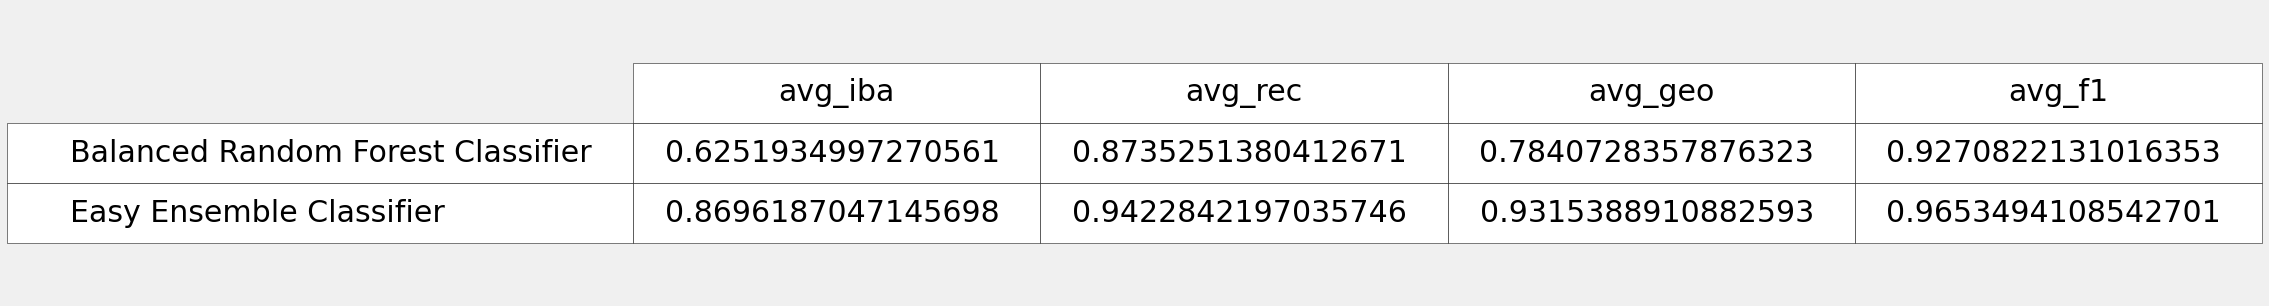

In [56]:
from pandas.plotting import table 
fig = plt.figure(figsize=(26,5))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ret_table = table(ax, df_model_analysis,loc="center");
ret_table.set_fontsize(44)
ret_table.scale(1,5)
ax.axis('off');
plt.savefig('../Images/summary_ensemble.jpg',bbox_inches = "tight")


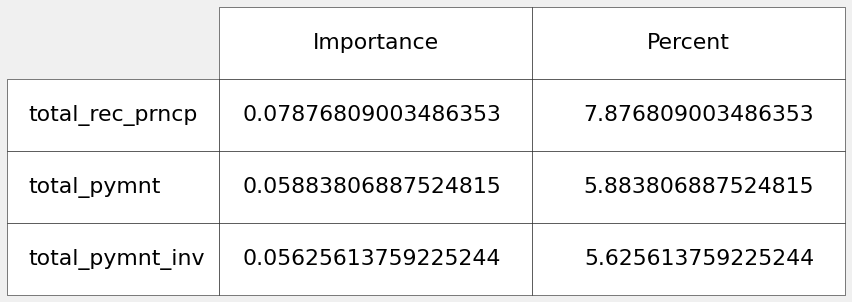

In [58]:
from pandas.plotting import table 
fig = plt.figure(figsize=(10,3))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ret_table = table(ax, feature_imp_df[:3],loc="center");
ret_table.set_fontsize(44)
ret_table.scale(1,6)
ax.axis('off');
plt.savefig('../Images/top_three_features.jpg',bbox_inches = "tight")

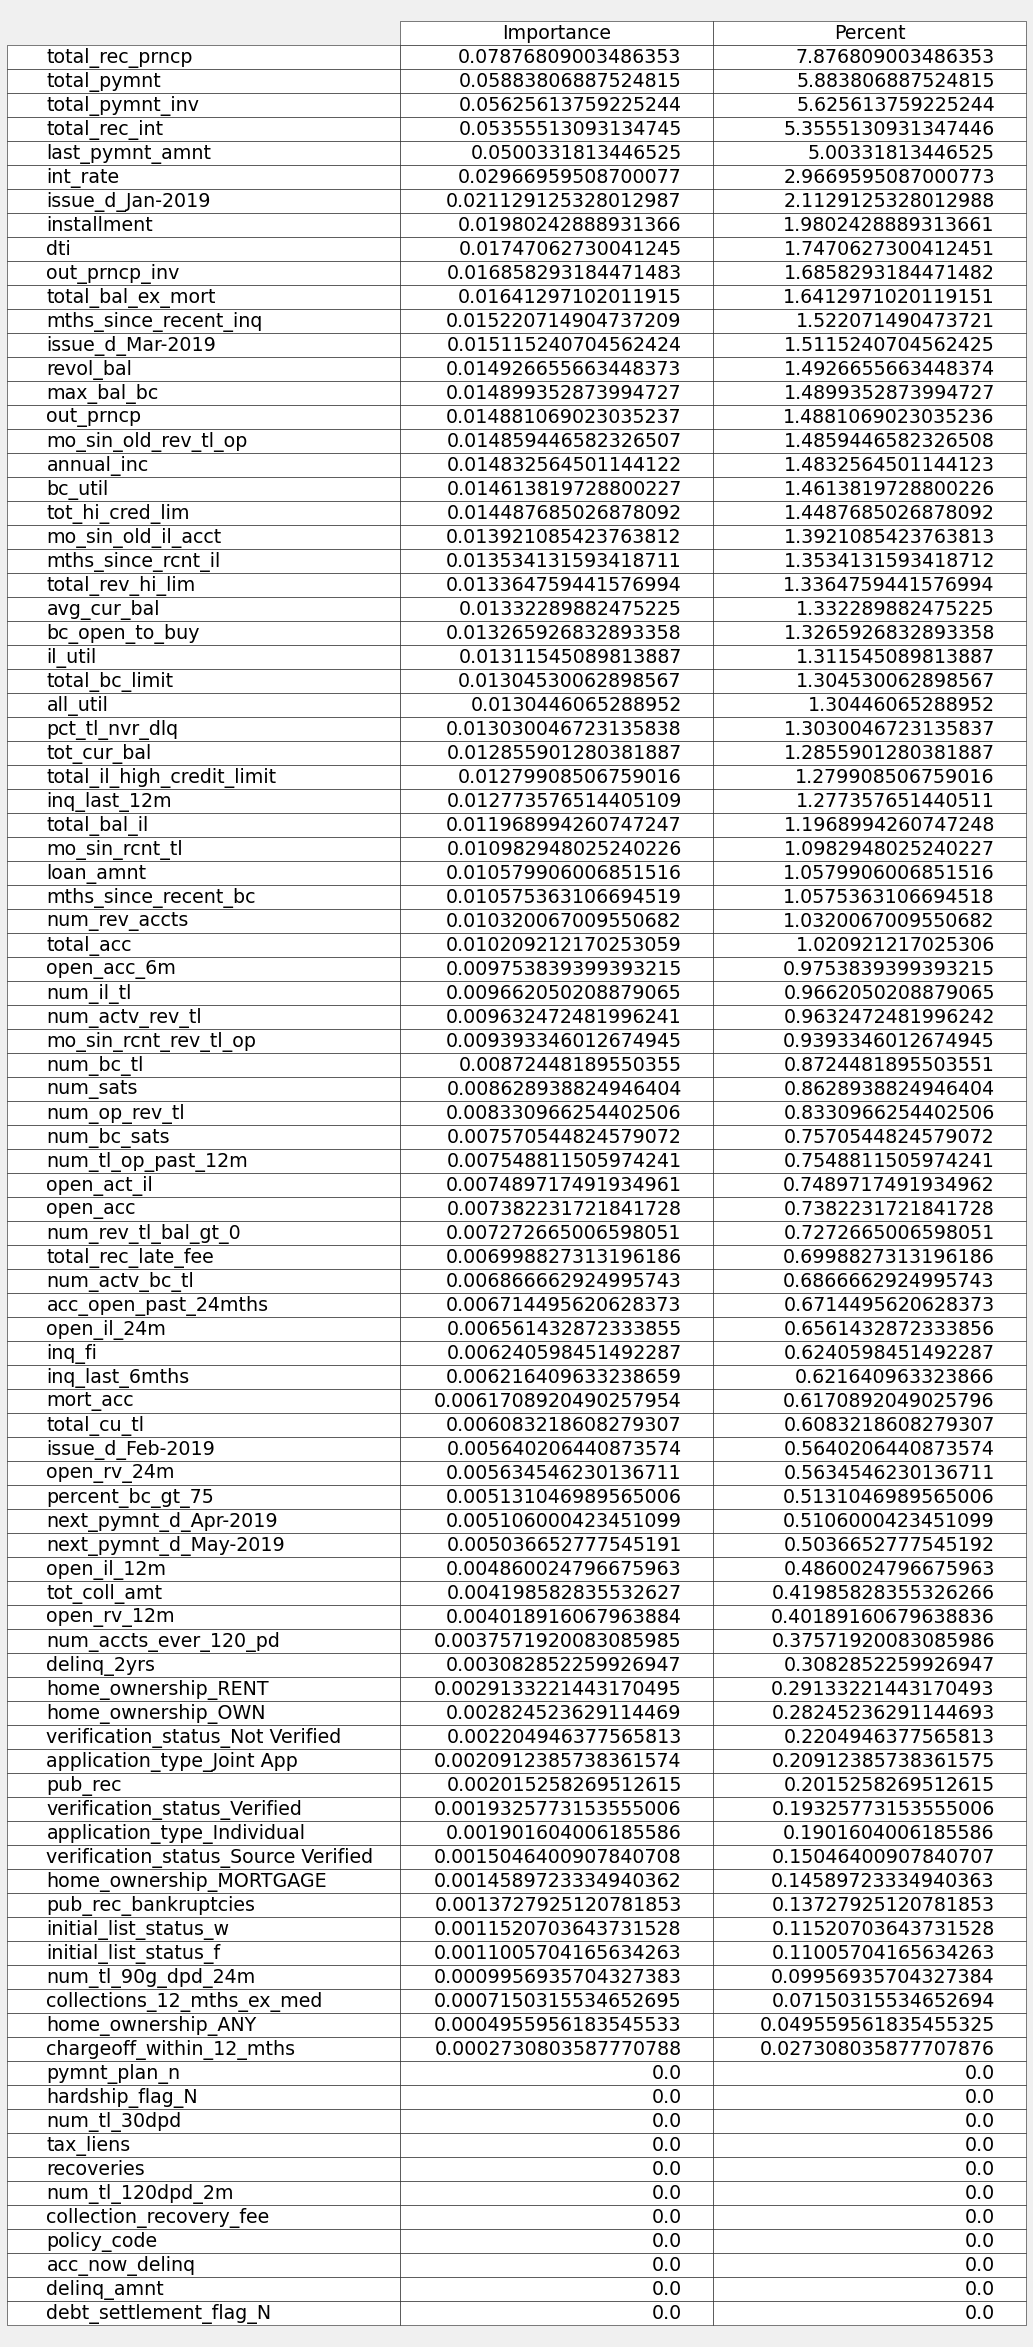

In [59]:
fig = plt.figure(figsize=(10,40))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ret_table = table(ax, feature_imp_df,loc="center");
ret_table.set_fontsize(20)
ret_table.scale(1,2)
ax.axis('off');
plt.savefig('../Images/feature_ranking.jpg',bbox_inches = "tight")